http://qutip.org/docs/latest/guide/guide-qip.html

In [1]:
import numpy as np
from qutip import *

from qutip.qip.circuit import QubitCircuit, Gate
from qutip.qip.operations import gate_sequence_product, rx
from qutip.qip.device import *
from qutip.qip import pulse

#print(qutip.qip.device__file__)

#import qip.ethprocessor as qip

### Create a quantum circuit

In [13]:
# Number of qubits in the system
N = 1

# Input state
input_states = ["0"]*N

# A list of integers for the dimension of each composite system.
dims = [3]*N

# Representation of a quantum program/algorithm, maintaining a sequence of gates.
qc = QubitCircuit(N = N, input_states = input_states, dims = dims, reverse_states = False)

qc.add_gate("RX", 0, None, np.pi, r"-\pi")

### Draw quantum circuit

In [14]:
qc.png

### Propagator

In [15]:
U_ideal = gate_sequence_product(qc.propagators())
U_ideal

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[0.+0.j 0.-1.j]
 [0.-1.j 0.+0.j]]

In [16]:
prop = qc.propagators()
prop[0]

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[0.+0.j 0.-1.j]
 [0.-1.j 0.+0.j]]

In [17]:
# energy levels
N = 3 # Qutrit

# Annihilation operator for the transmon
a = destroy(N)

# Qubit frequency (0->1) in MHz
omega = 2*np.pi*5.708390 * 1000

# Drive frequency in MHz
omega_drive = omega

# Self-Kerr coefficient (anharmonicity) in MHz
alpha = - 2*np.pi*261.081457

# Set rotating frame frequency (should be close to qubit frequencies for fast simulations)
rotating_frame = omega_drive #2*np.pi*5.0 * 1000

# Transmon Hamiltonian in rotating frame
H_qubit = (omega-rotating_frame) * a.dag() * a + alpha / 2 * pow(a.dag(),2) * pow(a,2)

# Drive Hamiltonian (since we have drag pulses, we need both x and y drive)
H_drive_x = a.dag() + a
H_drive_y = 1j*(a.dag() - a)

# Gaussian width in μs
sigma = 0.010 # = 10 ns

# Gate time in μs
L = 0.050 # = 50 ns

def H_drive_coeff_x(t, args):
    
    # Amplitude, needs to be optimized to get perfect pi pulse or pi/2 pulse
    B = args['amp']
    
    # DRAG-parameter, needs to be optimized to get no phase errors in a pi/2 pulse
    q = args['qscale']
    
    drive_freq = args['freq']
    
    # E(t)
    E = B * np.exp(-pow(t-0.5*L, 2) / (2*pow(sigma,2)))
    
    I = E
    Q = q * (t-0.5*L) / sigma * E # dE/dt
    return I*np.cos(drive_freq * t) + Q*np.sin(drive_freq * t)

def H_drive_coeff_y(t, args):
    
    # Amplitude, needs to be optimized to get perfect pi pulse or pi/2 pulse
    B = args['amp']
    
    # DRAG-parameter, needs to be optimized to get no phase errors in a pi/2 pulse
    q = args['qscale']
    
    drive_freq = args['freq']
    
    # E(t)
    E = B * np.exp(-pow(t-0.5*L, 2) / (2*pow(sigma,2)))
    
    I = E
    Q = -q * (t-0.5*L) / sigma * E # dE/dt
    return Q*np.cos(drive_freq * t) + I*np.sin(drive_freq * t)

# total Hamiltonian
H = [H_qubit,
     [H_drive_x,H_drive_coeff_x],
     [H_drive_y,H_drive_coeff_y],  
    ]

## Find the amplitude that corresponds to a $\pi$-pulse

In [18]:
# Total time in μs
t_total = L
tlist = np.linspace(0,t_total,500)

args = {'amp': 1, 'qscale': 0.018, 'freq': (rotating_frame - omega_drive)}

# in-phase component
I = H_drive_coeff_x(tlist, args)
# out of-phase component
Q = H_drive_coeff_y(tlist, args)

# Integrate along the given time-axis using the composite trapezoidal rule
B = np.pi/(2*np.abs(np.trapz(I + 1j*Q, x=tlist)))
print('Amplitude =',B)

Amplitude = 63.45380720748712


In [19]:
args = {'amp': B, 'qscale': 0.032, 'freq': (rotating_frame - omega_drive)}
# in-phase component
I = H_drive_coeff_x(tlist, args)
# out of-phase component
Q = H_drive_coeff_y(tlist, args)

In [20]:
from qutip.qip.device import Processor
proc = Processor(N=1, dims = [3], spline_kind = "cubic")

proc.add_control(H_drive_x, targets = 0, cyclic_permutation = True, label="I")
proc.add_control(H_drive_y, targets = 0, cyclic_permutation = True, label="Q")

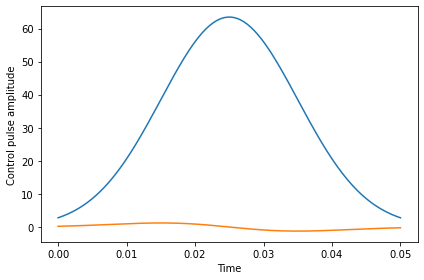

In [21]:
from qutip.qip.device import Processor
proc = Processor(N=1, dims = [3], spline_kind = "cubic")

proc.add_control(H_drive_x, targets = 0, cyclic_permutation = True, label="I")
proc.add_control(H_drive_y, targets = 0, cyclic_permutation = True, label="Q")

# the intrinsic evolution of the quantum system
proc.add_drift(H_qubit, targets = 0, cyclic_permutation = True)

proc.pulses[0].coeff = np.array(I)
proc.pulses[0].tlist = np.array(tlist)
proc.pulses[1].coeff = np.array(Q)
proc.pulses[1].tlist = np.array(tlist)

#for pulse in proc.pulses:
#    pulse.print_info()
proc.plot_pulses();

In [22]:
basis0 = basis(3, 0)
result = proc.run_state(init_state = basis0)
final_state = result.states[-1]

In [25]:
# unitary matrix to into transmon frame
rotate_U = Qobj([[1,0,0],
                 [0,np.exp(1j*(omega-rotating_frame)*t_total),0],
                 [0,0,np.exp(1j*(omega+alpha-rotating_frame)*t_total)]])

#rotate_U = (1j*H_qubit*t_total).expm()
                 
# rotated transmon state 
final_state = rotate_U*final_state

# project onto qubit subspace
#qubit_state = (basis(2,0)*basis(3,0).dag() + basis(2,1)*basis(3,1).dag())*final_state
qubit_state = Qobj(final_state.data[0:2], dims = [[2],[1]])

# normalize qubit state
qubit_state_norm = qubit_state / qubit_state.norm()

# target state
target_state = basis(2,1)

# fidelity
fid = fidelity(target_state, qubit_state_norm)
print('Fidelity = %s %%' % round(fid*100,4)) # Should be close to 100 %

Fidelity = 100.0 %


In [26]:
qubit_state_norm.tidyup(1.0e-3)

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[ 0.       +0.j        ]
 [-0.0434459-0.99905554j]]

In [ ]:
tensor(destroy(2))

In [ ]:
destroy(4)